In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
import spacy
from gensim import corpora
from gensim.models import LdaModel, Phrases, TfidfModel
from gensim.models.phrases import Phraser
from nltk import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from tqdm import tqdm

from wordcloud import WordCloud

import matplotlib.colors as mcolors

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

nltk.download('punkt')
# !python3 -m spacy download en

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

color_pallete = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Feedback Analysis

In [42]:
feedback_df = pd.read_csv('../Menagerie/data/grades.csv', index_col=0)
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Summary Analysis
### Count of submissions with no feedback

In [43]:
count_df = feedback_df.groupby('skill').count().reset_index()
count_df['missing'] = count_df['assignment_number'] - count_df['comments']
count_df

,skill,assignment_number,comments,participant_id,batch,grade,missing
0,Code Elegance,1120,677,1120,1120,1120,443
1,Correctness,1116,714,1116,1116,1116,402
2,Documentation,1118,710,1118,1118,1118,408
3,Readability,1120,631,1120,1120,1120,489


<Axes: xlabel='skill', ylabel='missing'>

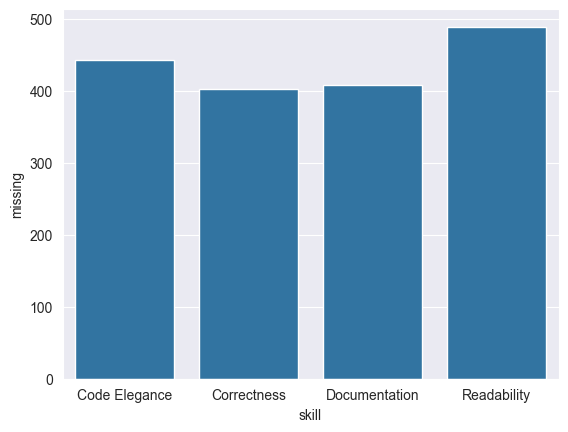

In [44]:
# Maybe add a plot of count of missing at each grade?
sns.barplot(count_df, x='skill', y='missing')

### NLP Techniques

In [45]:
nlp_df = feedback_df[~feedback_df['comments'].isna()].copy()
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++


In [46]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords += ['readability', 'correctness', 'documentation', 'maintainability', 'student']

### Sentiment

In [47]:
sia = SentimentIntensityAnalyzer()

def is_positive(comment):
    return sia.polarity_scores(comment)['compound'] > 0

nlp_df['sentiment'] = nlp_df['comments'].apply(is_positive)
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,sentiment
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,True
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,True
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,True
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,True
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,True
...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,False
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,False
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,True
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,True


In [48]:
sentiment_df = nlp_df[['skill', 'sentiment', 'assignment_number']].groupby(['skill', 'sentiment']).count().reset_index()
sentiment_df.columns = ['skill', 'sentiment', 'count']
sentiment_df['sentiment'] = sentiment_df['sentiment'].apply(lambda x: 'Positive' if x else 'Negative')
sentiment_df

,skill,sentiment,count
0,Code Elegance,Negative,221
1,Code Elegance,Positive,456
2,Correctness,Negative,261
3,Correctness,Positive,453
4,Documentation,Negative,250
5,Documentation,Positive,460
6,Readability,Negative,152
7,Readability,Positive,479


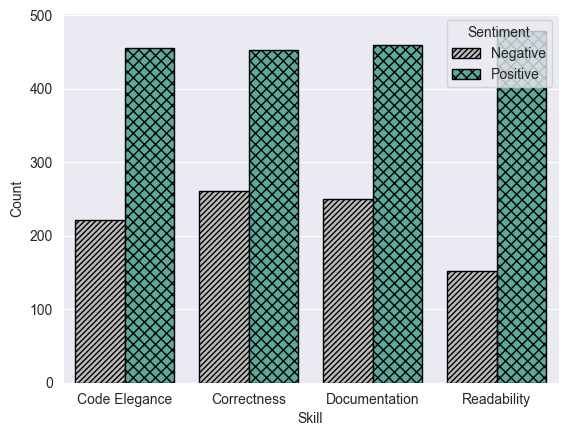

In [49]:
g = sns.barplot(sentiment_df, x='skill', y='count', hue='sentiment')


hatches = ['//', 'x',]
colors = [grey, teal]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, g.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

g.set(xlabel='Skill', ylabel='Count')
handles = g.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')

g.legend(title='Sentiment')
g.get_figure().savefig('../plots/sentiment.pdf', bbox_inches='tight')

### LDA Topic Analysis
https://link.springer.com/article/10.1007/s44217-023-00051-0
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9260886/

Code adapted from: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#4.-Build-the-Bigram,-Trigram-Models-and-Lemmatize

In [50]:
# TODO: Build LDA for correctness, readability and maintainability
# TODO: Add plots for dominant topic per document
# TODO: Add plots for word counts of topic key words

In [51]:
def process_words(texts, bigram_mod, trigram_mod, stop_words=stopwords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stem=False):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    if stem:
        stemmer = SnowballStemmer('english')
        texts_out = [[stemmer.stem(word) for word in doc] for doc in texts_out]
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]

    return texts_out

In [52]:
def get_data(skill):
    text_data = nlp_df[nlp_df['skill'] == skill]['comments']
    bigram = Phrases(text_data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = Phrases(bigram[text_data], threshold=100)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)

    processed_text = process_words(text_data, bigram_mod, trigram_mod, stem=False, allowed_postags=['NOUN'])
    dictionary = corpora.Dictionary(processed_text)
    dictionary.filter_extremes(no_below=15, no_above=0.3, keep_n=10000)
    corpus = [dictionary.doc2bow(text) for text in processed_text]

    model = TfidfModel(corpus)
    tfidf_corpus = [model[i] for i in corpus]
    
    return tfidf_corpus, dictionary, processed_text
    

In [53]:
def generate_topic_model(corpus, dictionary, processed_text, num_topics=5):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=10, passes=15)
    cm = CoherenceModel(model=lda_model, texts=processed_text, coherence='u_mass')
    coherence = cm.get_coherence()
    return lda_model, coherence


In [65]:
def generate_topic_models(tfidf_corpus, dictionary, processed_text):
    models = {}
    coherence_results = []
    
    for topic_count in tqdm([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100]):
        model, coherence = generate_topic_model(tfidf_corpus, dictionary, processed_text, topic_count)
        models[topic_count] = model
        coherence_results.append({'topic_count':topic_count, 'coherence': coherence})
        
    return models, pd.DataFrame(coherence_results)
    

In [66]:
def run_lda(skill):
    tfidf_corpus, dictionary, processed_text = get_data(skill)
    models, coherence_df= generate_topic_models(tfidf_corpus, dictionary, processed_text)
    print(coherence_df)

    g = sns.lineplot(coherence_df, x='topic_count', y='coherence')
    g.set(title=skill)
    return models, tfidf_corpus

#### Plots

In [73]:
def run_pyLDAvis(models, topic_count):
    return pyLDAvis.gensim.prepare(models[topic_count], corpus, dictionary=models[topic_count].id2word)

In [91]:
def generate_word_cloud(models, topic_count, topic_names=None):
    if topic_names is not None:
        if len(topic_names) < topic_count:
            print('Not enough topic names to generate word cloud')
            return None
        elif len(topic_names) > topic_count:
            print('Too many topic names to generate word cloud')
            return None
        
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stopwords,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=15,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    
    topics = models[topic_count].show_topics(formatted=False, num_words=5)
    
    fig, axes = plt.subplots((int(topic_count) // 2) + int(topic_count) % 2, 2, figsize=(10,10), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        if topic_names is None:
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        else:
            plt.gca().set_title('Topic: ' + topic_names[i], fontdict=dict(size=16))
        plt.gca().axis('off')
    
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

### Readability

100%|██████████| 15/15 [00:04<00:00,  3.14it/s]

    topic_count  coherence
0             1  -9.973276
1             2 -11.021087
2             3 -10.291943
3             4  -9.616342
4             5  -9.400095
5             6 -10.160412
6             7  -9.310493
7             8  -9.837167
8             9  -9.744100
9            10 -10.077557
10           20 -12.246489
11           30 -11.947619
12           40 -11.913439
13           50 -11.892017
14          100 -11.901901


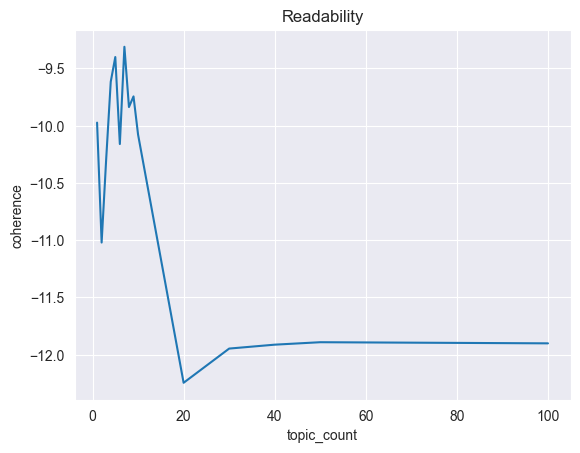

In [67]:
models, corpus = run_lda('Readability')

IndexError: list index out of range

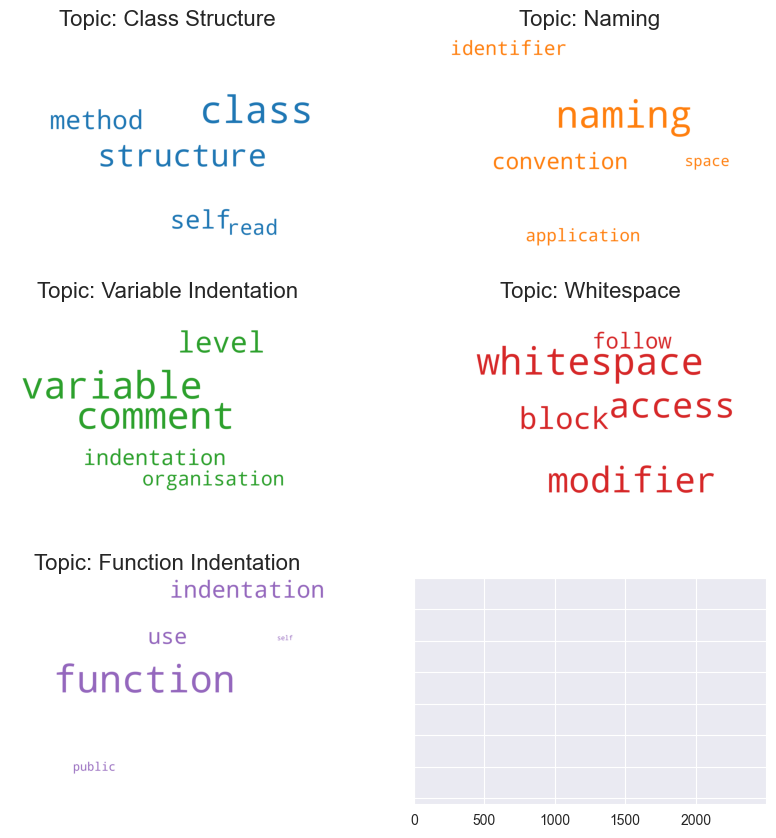

In [104]:
TOPIC_COUNT = 5
generate_word_cloud(models, TOPIC_COUNT, topic_names=['Class Structure', 'Naming', 'Variable Indentation', 'Whitespace', 'Function Indentation'])
run_pyLDAvis(models, TOPIC_COUNT)